# EDA: Timeseries Analysis 

Use of basic and advanced techniques for timeseries analysis and prediction of crypto-currencies prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('../data/bitcoin_price.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Oct 03, 2017",4408.46,4432.47,4258.89,4317.48,"1,288,020,000","73,181,300,000"
1,"Oct 02, 2017",4395.81,4470.23,4377.46,4409.32,"1,431,730,000","72,963,200,000"
2,"Oct 01, 2017",4341.05,4403.74,4269.81,4403.74,"1,208,210,000","72,047,300,000"
3,"Sep 30, 2017",4166.11,4358.43,4160.86,4338.71,"1,207,450,000","69,136,600,000"
4,"Sep 29, 2017",4171.62,4214.63,4039.29,4163.07,"1,367,050,000","69,219,200,000"


In [3]:
data['Date']=pd.to_datetime(data['Date'], format='%b %d, %Y')
close_price = data[['Date','Close']]
close_price.index = close_price['Date']
close_price_ts=close_price['Close']

# chronological order
close_price_ts=close_price_ts.sort_index()
close_price_ts.head()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64

## Do we have missing values?

In [4]:
nan_values=pd.isnull(close_price_ts)
nan_values[nan_values==True]

Series([], Name: Close, dtype: bool)

There are no values missing. Great news !

## Temporal structure

### Raw signal

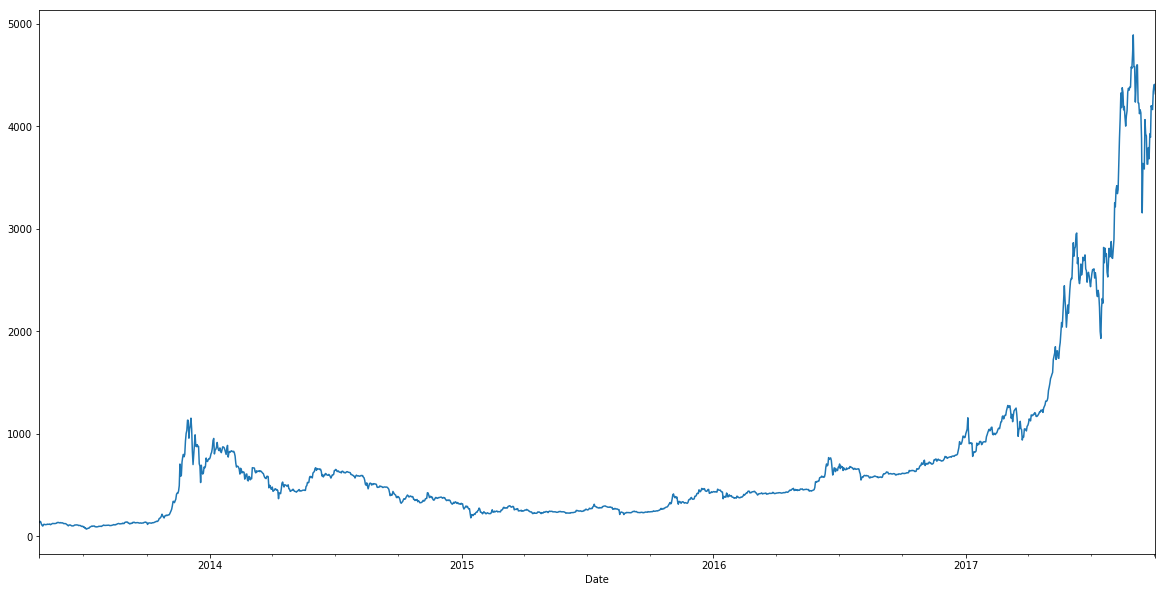

In [5]:
plt.figure(figsize=(20,10))
close_price_ts.plot()
plt.show()

### Lag plot

In general, the lag plot can indicate us whether there is high autocorrelation in the signal or not

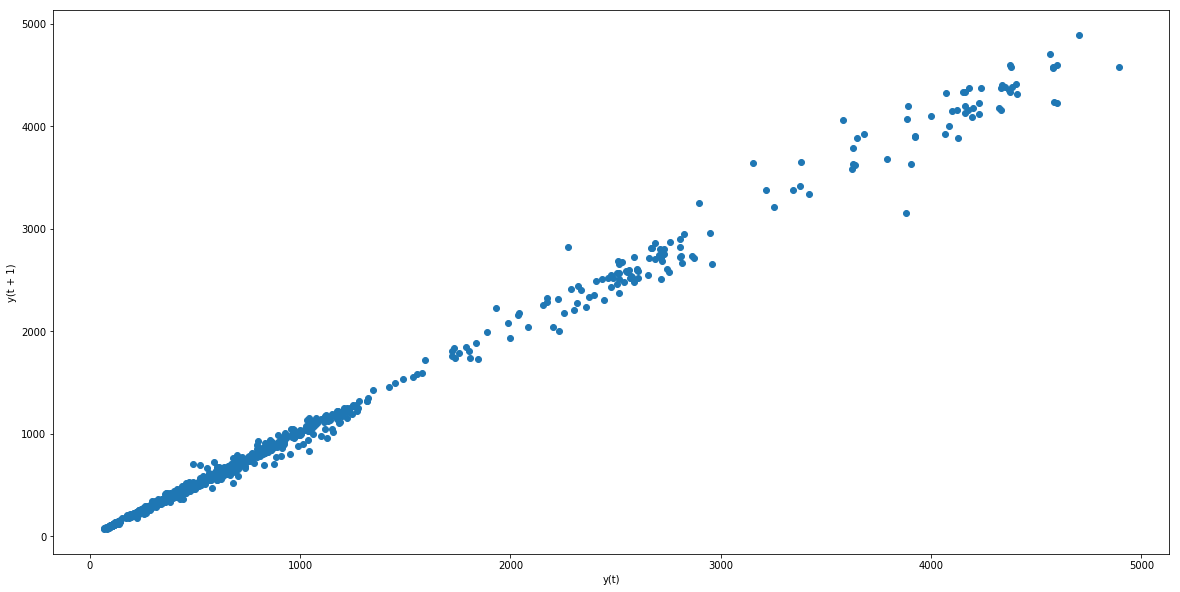

In [6]:
from pandas.plotting import lag_plot

plt.figure(figsize=(20,10))
lag_plot(close_price_ts)
plt.show()

This lag plot shows a linear pattern. So the signal does not seem random at all. Therefore ARIMA might work well.

### Autocorrelation plot

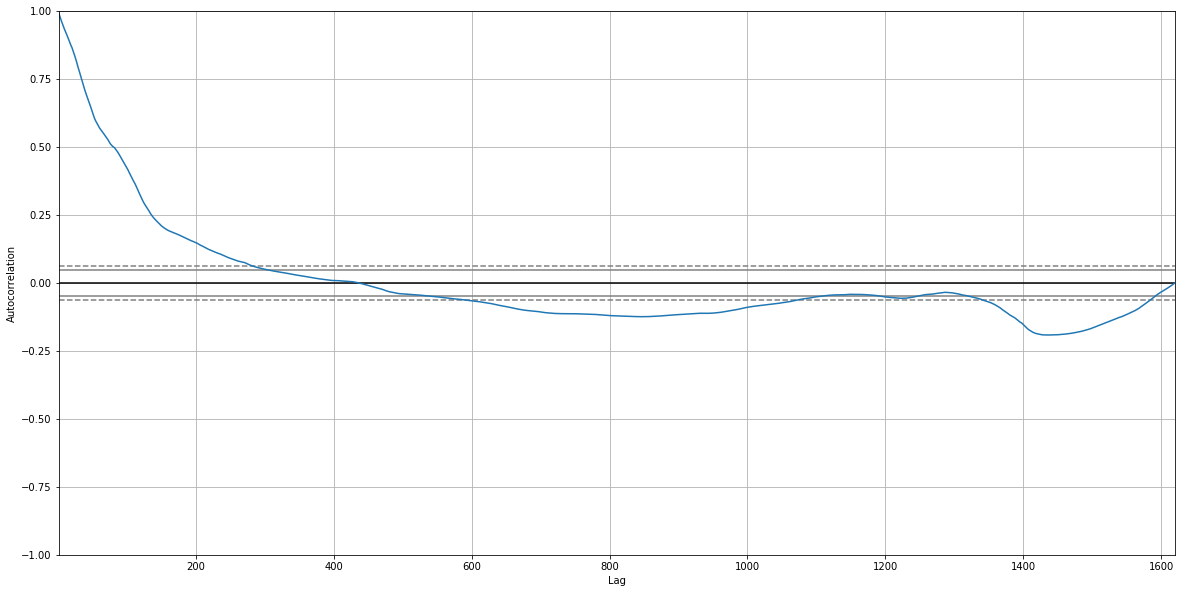

In [7]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,10))
autocorrelation_plot(close_price_ts)
plt.show()



## Distribution

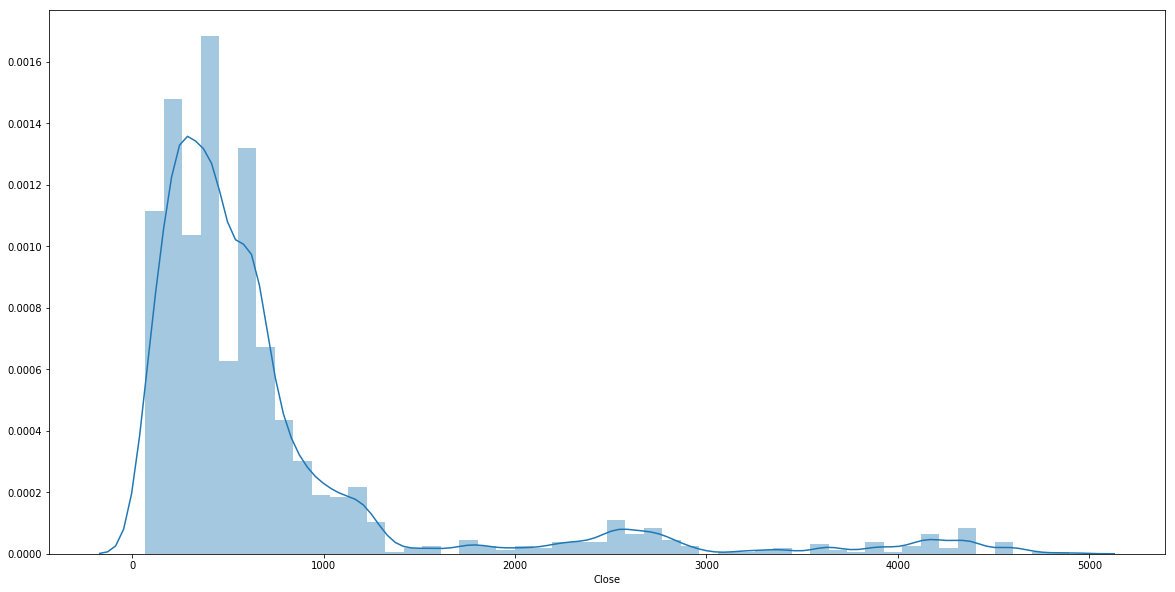

In [8]:
plt.figure(figsize=(20,10))
sns.distplot(close_price_ts)
plt.show()

## Changes over time

### Boxplot

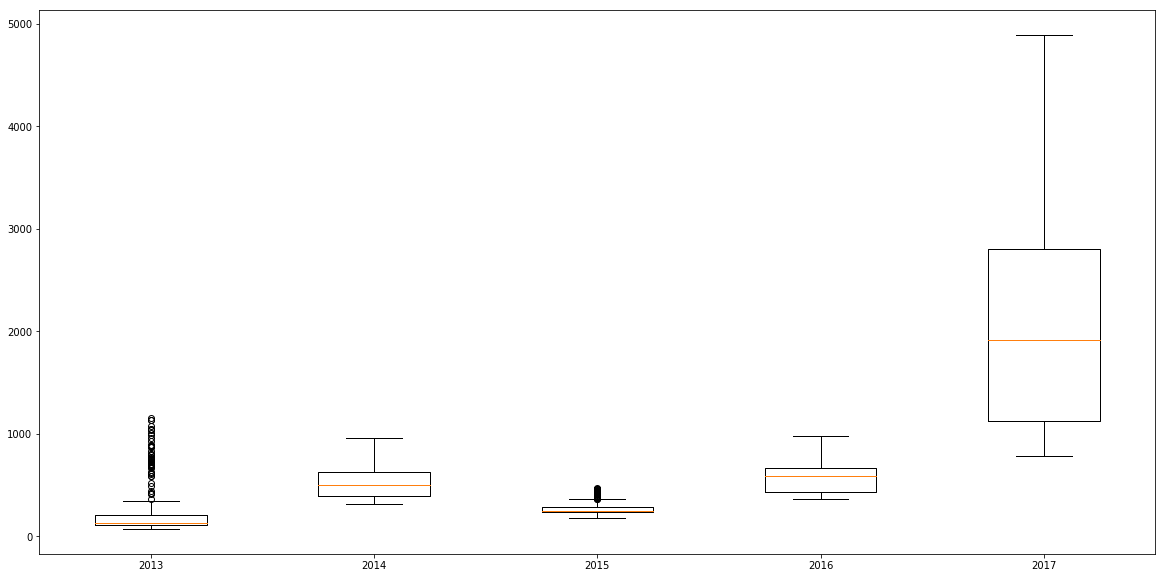

In [9]:
from pandas import TimeGrouper
groups = close_price_ts.groupby(TimeGrouper('A'))

data=[]
years=[]
x_i=1
x=[]
for name, group in groups:
    x.append(x_i)
    data = data+[group.values]
    years.append(name.year)
    x_i+=1
    
# multiple box plots on one figure
plt.figure(figsize=(20,10))
plt.boxplot(data)
plt.xticks(x, years)
plt.show()

Major increase in 2017 with more variability. Therefore, volatitility has increased in 2017.

## Transformations of the signal

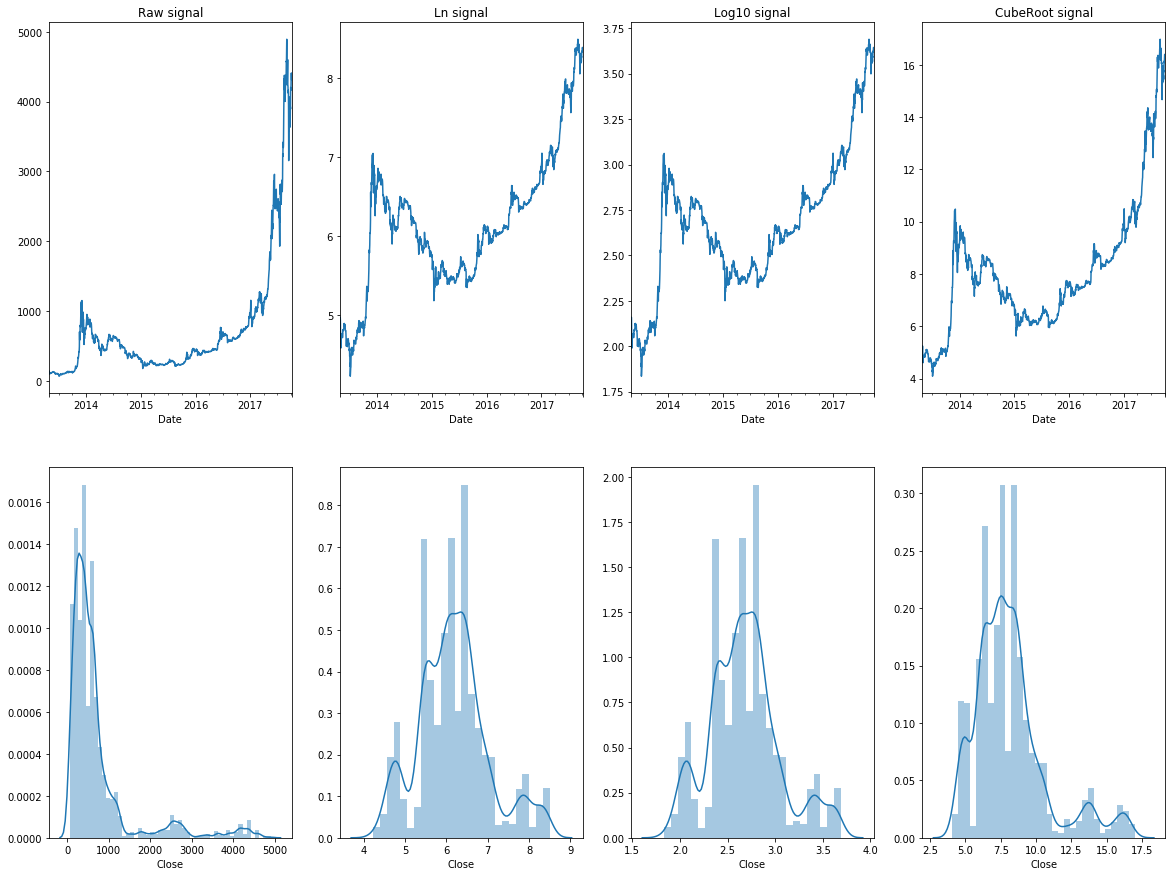

In [10]:
close_price_ts_ln = close_price_ts.apply(lambda x: np.log(x))
close_price_ts_log = close_price_ts.apply(lambda x: np.log10(x))
close_price_ts_cuberoot = close_price_ts.apply(lambda x: x**(1./3.))

plt.figure(figsize=(20,15))

plt.subplot(2,4,1)
close_price_ts.plot()
plt.title('Raw signal')

plt.subplot(2,4,2)
close_price_ts_ln.plot()
plt.title('Ln signal')

plt.subplot(2,4,3)
close_price_ts_log.plot()
plt.title('Log10 signal')

plt.subplot(2,4,4)
close_price_ts_cuberoot.plot()
plt.title('CubeRoot signal')

plt.subplot(2,4,5)
sns.distplot(close_price_ts)

plt.subplot(2,4,6)
sns.distplot(close_price_ts_ln)

plt.subplot(2,4,7)
sns.distplot(close_price_ts_log)

plt.subplot(2,4,8)
sns.distplot(close_price_ts_cuberoot)


plt.show()

## Time lag

The idea here is to see if there is a relationship between time lags

In [11]:
print(close_price_ts.shift(0).head())
print()
print(close_price_ts.shift(1).head())
print()
print(close_price_ts.shift(2).head())
print()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64
()
Date
2013-04-28       NaN
2013-04-29    134.21
2013-04-30    144.54
2013-05-01    139.00
2013-05-02    116.99
Name: Close, dtype: float64
()
Date
2013-04-28       NaN
2013-04-29       NaN
2013-04-30    134.21
2013-05-01    144.54
2013-05-02    139.00
Name: Close, dtype: float64
()


In [12]:
lagmax=30
all_lags = list(range(1,lagmax+1))

lagged_data = pd.concat([close_price_ts]+[close_price_ts.shift(i) for i in all_lags],axis=1,
                       keys=['original']+['Lag%d' % j for j in all_lags]).dropna()
lagged_data.head()

,original,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag21,Lag22,Lag23,Lag24,Lag25,Lag26,Lag27,Lag28,Lag29,Lag30
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-28,129.0,129.75,133.48,131.98,133.20,126.70,123.89,122.88,122.00,121.99,...,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00,144.54,134.21
2013-05-29,132.3,129.00,129.75,133.48,131.98,133.20,126.70,123.89,122.88,122.00,...,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00,144.54
2013-05-30,128.8,132.30,129.00,129.75,133.48,131.98,133.20,126.70,123.89,122.88,...,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00
2013-05-31,129.0,128.80,132.30,129.00,129.75,133.48,131.98,133.20,126.70,123.89,...,117.20,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99
2013-06-01,129.3,129.00,128.80,132.30,129.00,129.75,133.48,131.98,133.20,126.70,...,115.24,117.20,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21


### Model the lags

In [13]:
import statsmodels.formula.api as smf
formula = 'original ~ trend'
for i in all_lags:
    formula = formula + ' + Lag%i'%i
model_lagged=smf.ols(formula, data=lagged_data.assign(trend=np.arange(len(lagged_data))))

res_lagged = model_lagged.fit()
print(res_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:               original   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Mon, 30 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:16:36   Log-Likelihood:                -8476.2
No. Observations:                1590   AIC:                         1.702e+04
Df Residuals:                    1558   BIC:                         1.719e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3320      2.561     -1.301      0.1

[  9.47884597e-01   4.89316719e-02   2.55860282e-02  -5.21752965e-02
   8.13146453e-02  -1.61983959e-02  -5.35620746e-02  -1.78615518e-02
   5.47165427e-02   1.00928402e-02   8.36980945e-03   9.03769863e-02
  -2.26029223e-01   1.00925423e-01   1.96702896e-03  -4.61678045e-04
   6.76173961e-02   1.26029796e-02  -5.61767498e-02  -2.15373033e-02
  -1.85551787e-01   1.96528576e-01  -1.47281977e-01   1.81485805e-01
   6.58915219e-02  -1.58863525e-01   1.63223833e-01  -3.21677862e-01
   3.43532022e-02   1.72171313e-01]
-1.30841262997


/Users/auguste/Documents/fibronostics_code/Envs/machine_learning/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


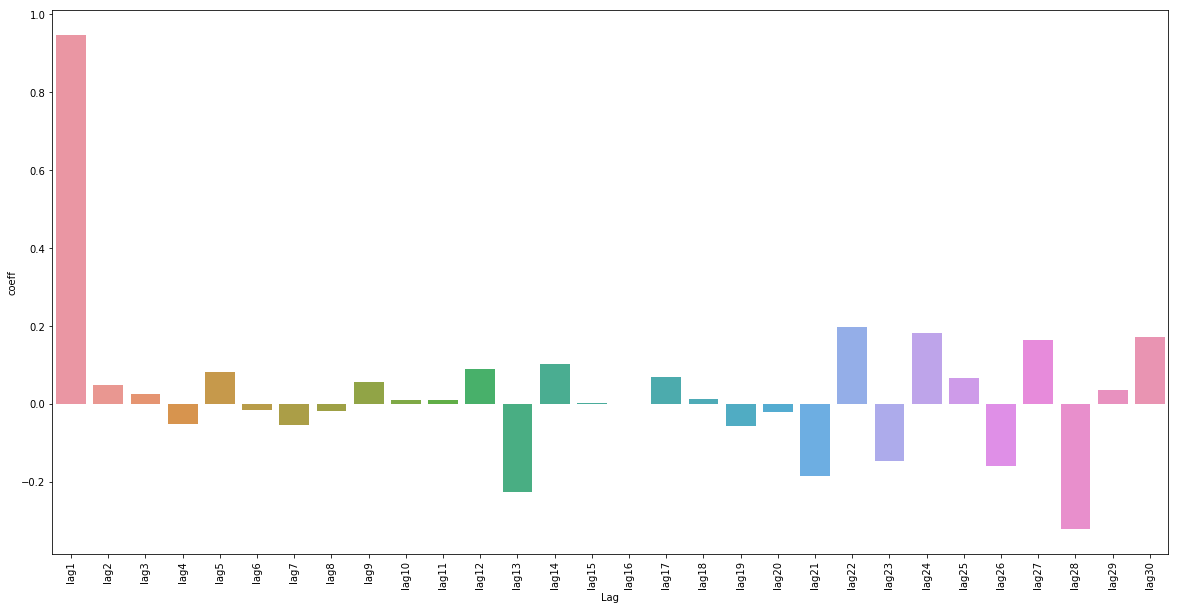

In [14]:
from sklearn.linear_model import LinearRegression
y = lagged_data['original'].values
X = lagged_data.drop('original',1).values

ols = LinearRegression()
ols.fit(X,y)
print(ols.coef_)
print(ols.intercept_)
ols_coefs_per_lag=pd.DataFrame({'Lag':['lag%d' %i for i in all_lags],'coeff':ols.coef_})

plt.figure(figsize=(20,10))
lag_coeff_barplot=sns.barplot(x='Lag',y='coeff',data=ols_coefs_per_lag)
for item in lag_coeff_barplot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Correlation between the lags

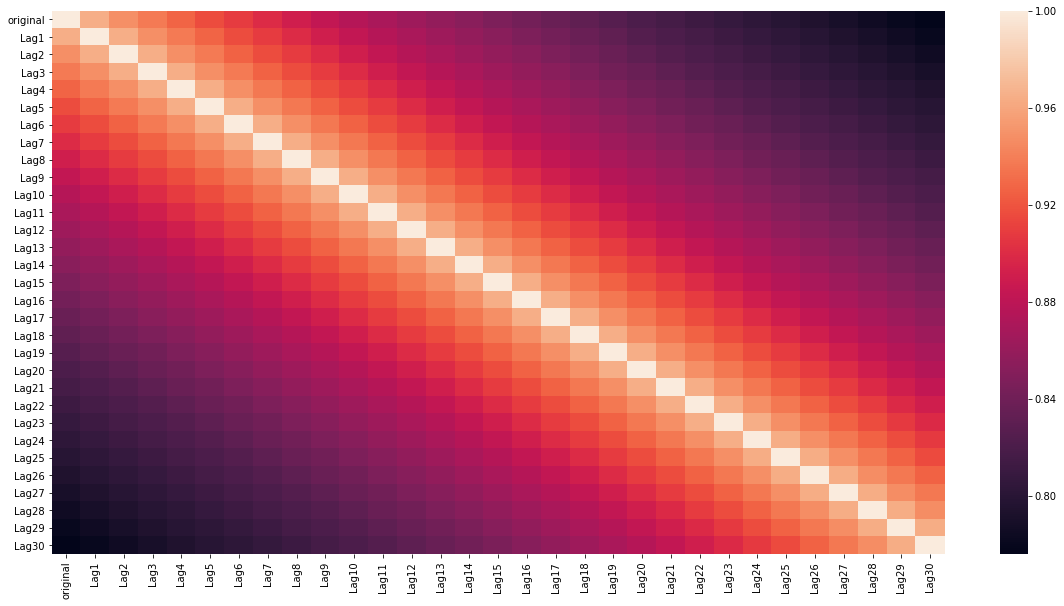

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(lagged_data.corr(method='kendall'))
plt.show()

## Signal decomposition

In [16]:
y = close_price_ts.copy()

# first differencing 
y_diff=y.diff().dropna()







### Compute trend

#### By differencing
source: https://machinelearningmastery.com/time-series-trends-in-python/

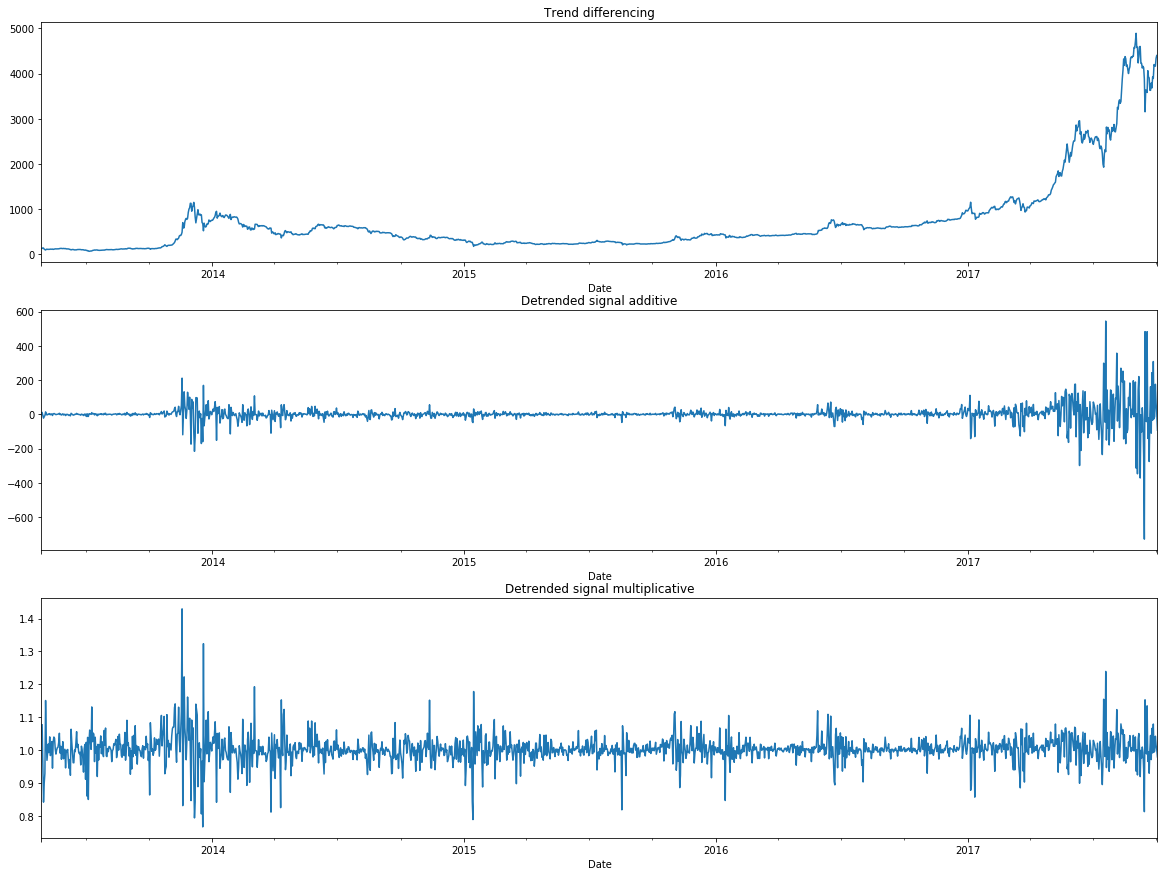

In [17]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
trend_diff = y - y_diff
trend_diff.plot()
plt.title('Trend differencing')

plt.subplot(3,1,2)
detrended_diff_add = y - trend_diff
detrended_diff_add.plot()
plt.title('Detrended signal additive')

plt.subplot(3,1,3)
detrended_diff_multi = y/trend_diff
detrended_diff_multi.plot()
plt.title('Detrended signal multiplicative')
plt.show()

#### With median/mean average

/Users/auguste/Documents/fibronostics_code/Envs/machine_learning/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=8,center=False).median()
  after removing the cwd from sys.path.


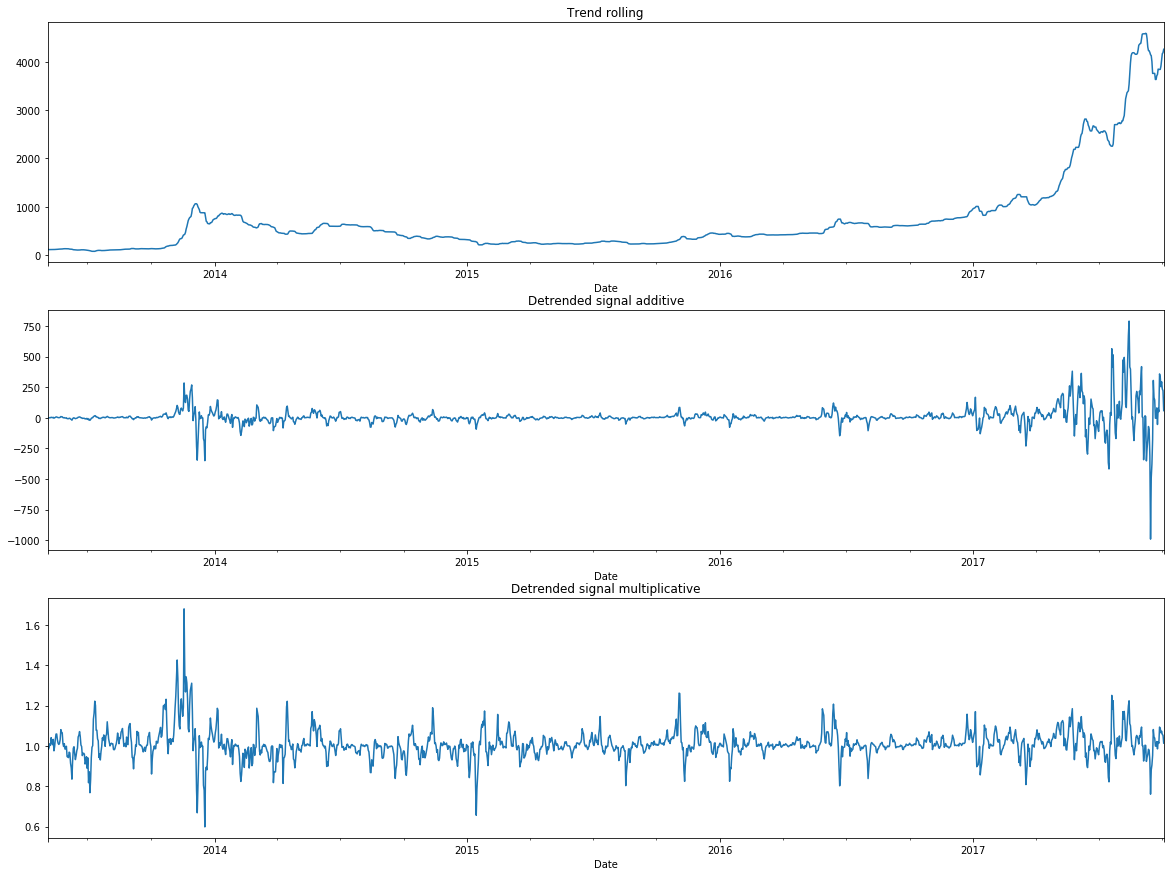

In [18]:
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
trend_rolling = pd.rolling_median(y,8)
trend_rolling.dropna().plot()
plt.title('Trend rolling')

plt.subplot(3,1,2)
detrended_rolling_add = y-trend_rolling
detrended_rolling_add.dropna().plot()
plt.title('Detrended signal additive')

plt.subplot(3,1,3)
detrended_rolling_mult = y/trend_rolling
detrended_rolling_mult.dropna().plot()
plt.title('Detrended signal multiplicative')
plt.show()

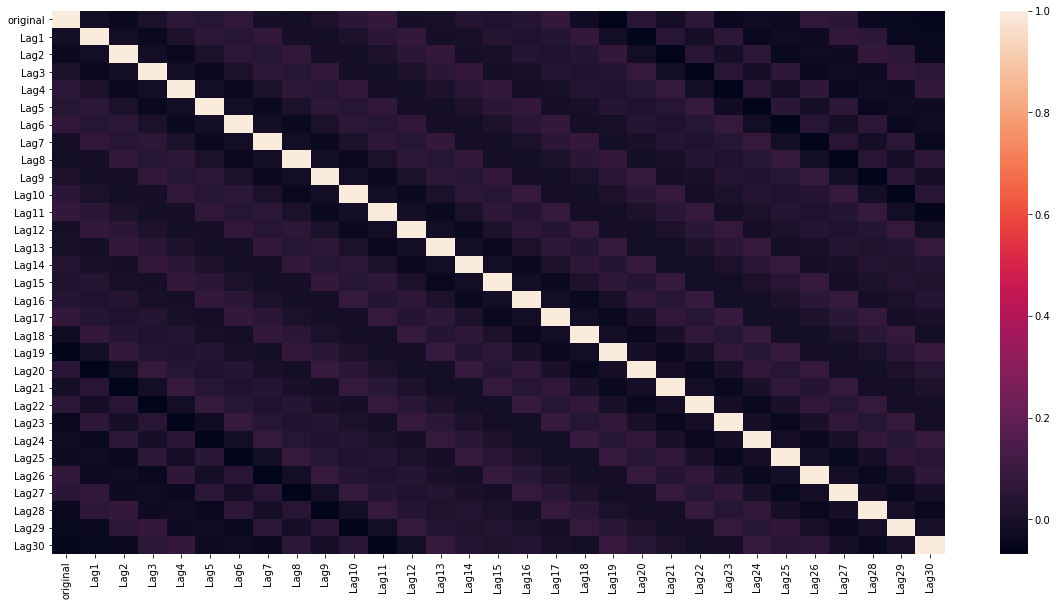

In [19]:
plt.figure(figsize=(20,10))
lagged_detrended = pd.concat([detrended_diff_multi]+[detrended_diff_multi.shift(i) for i in all_lags],axis=1,
                       keys=['original']+['Lag%d' % j for j in all_lags]).dropna()

sns.heatmap(lagged_detrended.corr(method='pearson'))
plt.show()

The detrended signal seems to have some degree of periodicity/seasonality


   ### Additive Decomposition 

/Users/auguste/Documents/fibronostics_code/Envs/machine_learning/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


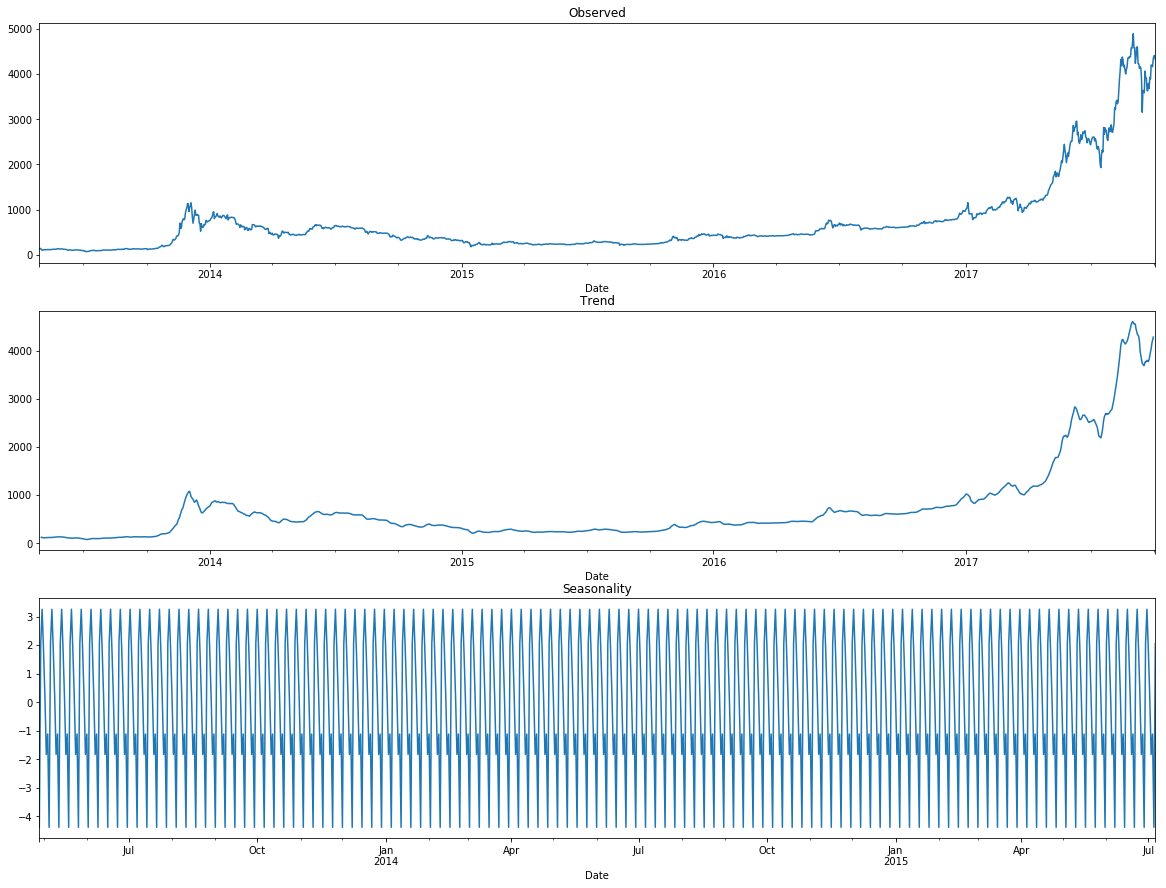

In [20]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='additive')

plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
decomposition.observed.plot()
plt.title('Observed')

plt.subplot(3,1,2)
decomposition.trend.plot()
plt.title('Trend')

plt.subplot(3,1,3)
decomposition.seasonal.head(800).plot()
plt.title('Seasonality')


plt.show()

### Multiplicative Decomposition

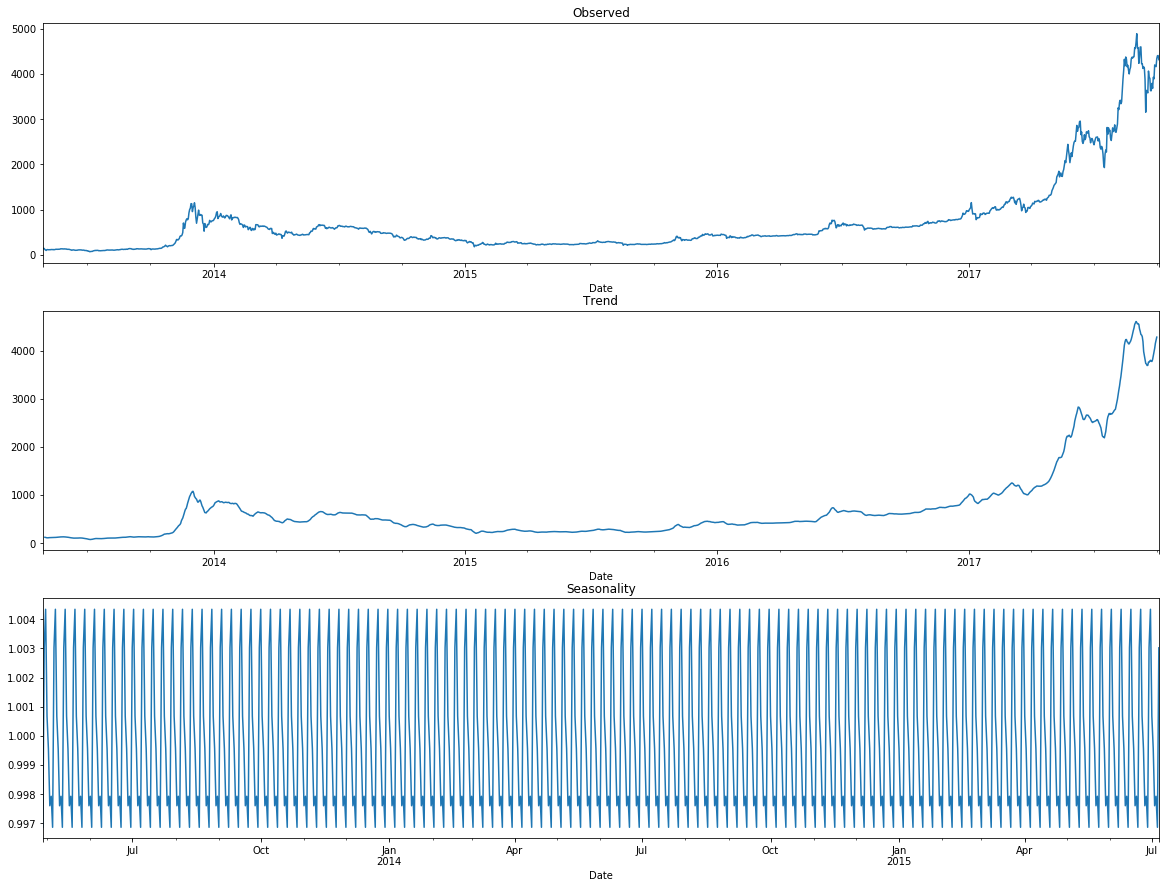

In [21]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
decomposition.observed.plot()
plt.title('Observed')

plt.subplot(3,1,2)
decomposition.trend.plot()
plt.title('Trend')

plt.subplot(3,1,3)
decomposition.seasonal.head(800).plot()
plt.title('Seasonality')


plt.show()


It appears here that we could pick either an additive or a multiplicative decomposition

## Stationarity

## Baseline forecasting model: Persistence Algorithm or 'Naive Forecast'

### Predict with the previous data point

In [22]:
baseline_data = pd.concat([close_price_ts.shift(1), close_price_ts], axis=1).dropna()
baseline_data.columns = ['t-1', 't']
baseline_data.head()

,t-1,t
Date,,
2013-04-29,134.21,144.54
2013-04-30,144.54,139.00
2013-05-01,139.00,116.99
2013-05-02,116.99,105.21
2013-05-03,105.21,97.75


### Define train and test datasets

In [23]:
X=baseline_data['t-1'].values
y=baseline_data['t'].values
n=len(X)
n_train=int(0.66*n)
n_test=n-n_train

X_train=X[:n_train]
X_test=X[n_train:]

y_train=y[:n_train]
y_test=y[n_train:]

### Persistence algo

In [24]:
# persistence model
def model_persistence(x):
    return x

### Evaluation of baseline model

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pred_baseline=[]
for x in X_test:
    pred = model_persistence(x)
    pred_baseline.append(pred)

baseline_mse = mean_squared_error(y_test,pred_baseline)
baseline_mae = mean_absolute_error(y_test,pred_baseline)
baseline_r2 = r2_score(y_test,pred_baseline)

print('baseline MSE:')
print(baseline_mse)
print('')
print('baseline MAE:')
print(baseline_mae)
print('')
print('baseline R2')
print(baseline_r2)


baseline MSE:
7345.18611887

baseline MAE:
41.5088021779

baseline R2
0.994441488566


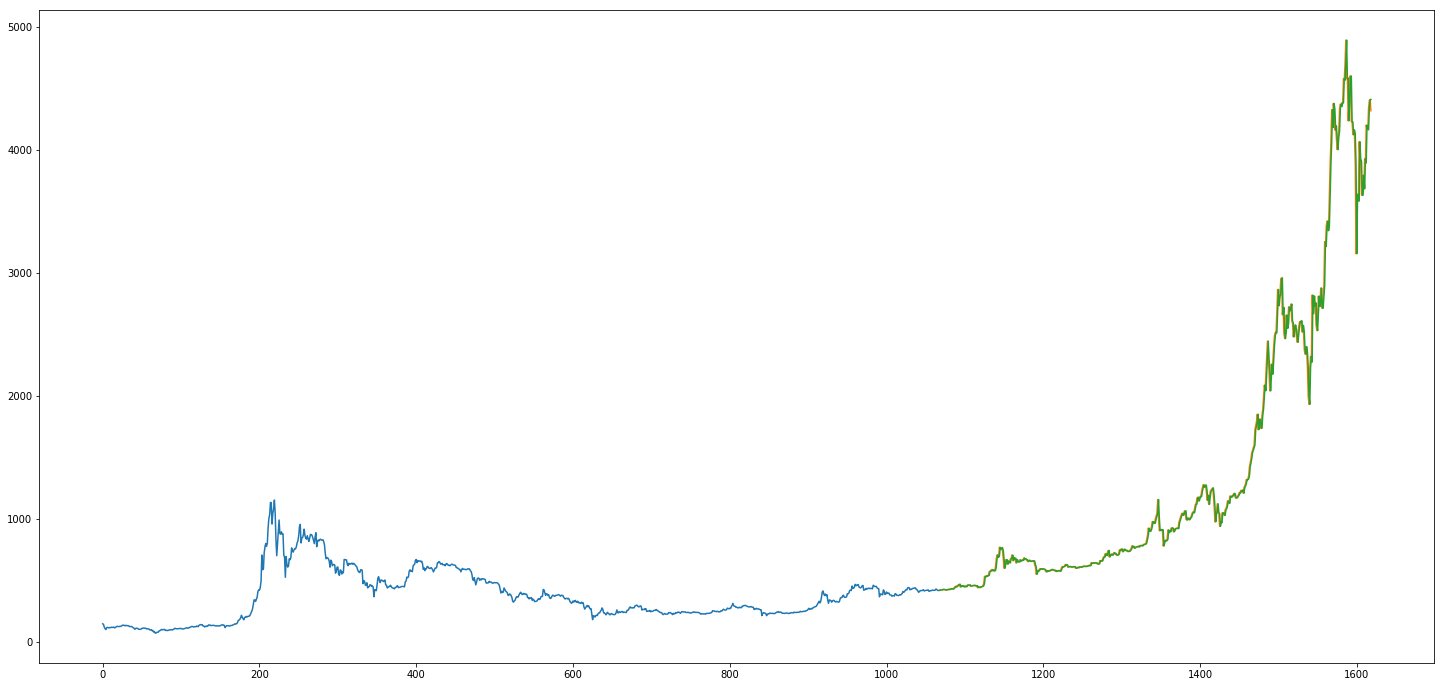

In [26]:
plt.figure(figsize=(25,12))
plt.plot(y_train)
plt.plot([None for i in y_train] + [x for x in y_test])
plt.plot([None for i in y_train] + [x for x in pred_baseline])
plt.show()

## AR model

Autoregressive: uses previous values as features to predict future values ('regression from itself')

### Autocorrelation

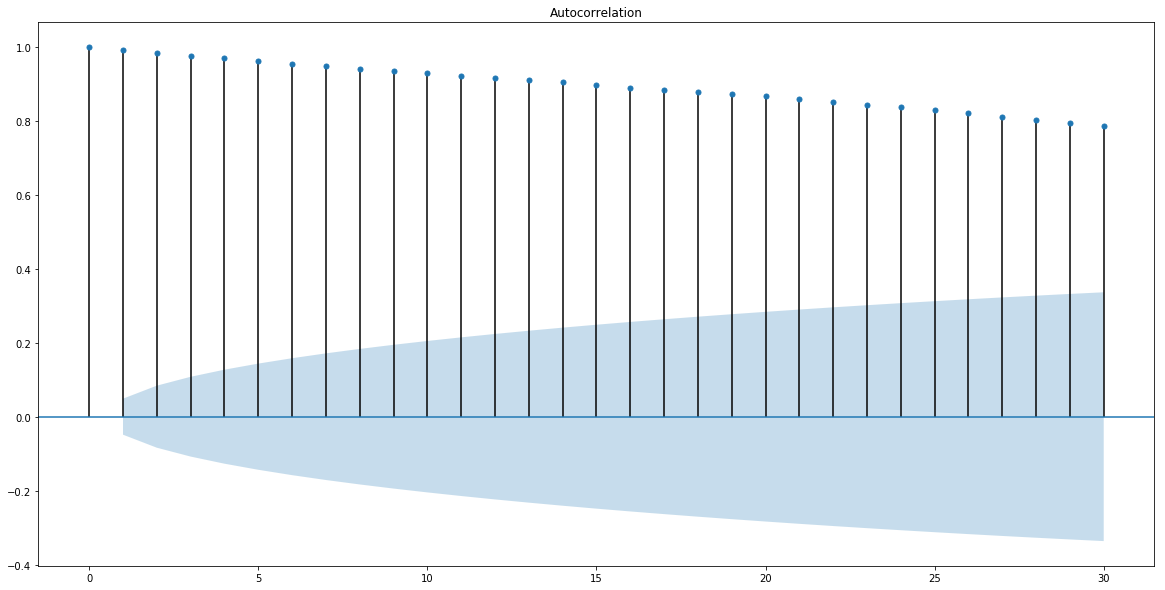

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plot_acf(close_price_ts, lags=lagmax,ax=ax)
plt.show()

In [30]:
ratio_train = 0.90

### AR modeling with statsmodels

Lag: 23
Coefficients: const        1.476268
L1.Close     0.996417
L2.Close    -0.063100
L3.Close    -0.027690
L4.Close     0.159686
L5.Close    -0.003623
L6.Close     0.035062
L7.Close    -0.100218
L8.Close    -0.007446
L9.Close    -0.007435
L10.Close    0.033889
L11.Close    0.055238
L12.Close   -0.060187
L13.Close    0.016953
L14.Close    0.000802
L15.Close   -0.058053
L16.Close    0.024934
L17.Close    0.041959
L18.Close   -0.141855
L19.Close   -0.036498
L20.Close    0.171322
L21.Close   -0.096340
L22.Close    0.096408
L23.Close   -0.031633
dtype: float64

Train MSE: 559.423
Train MAE: 12.427
Train R2: 0.992

Test MSE: 3957455.993
Test MAE: 1736.319
Test R2: -3.294


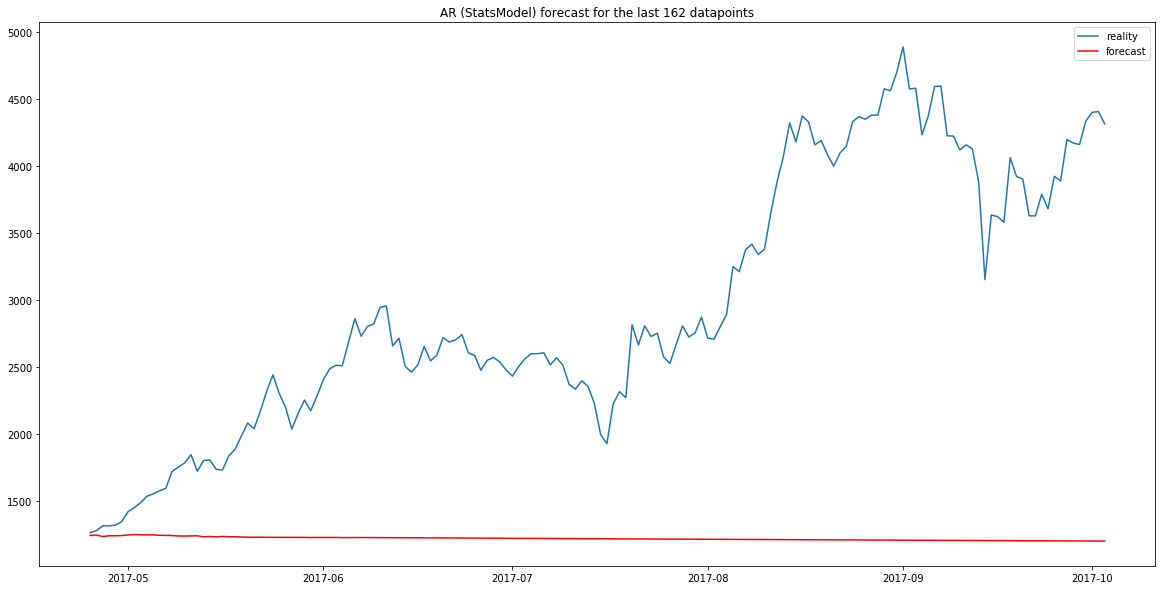

In [64]:
from statsmodels.tsa.ar_model import AR
X=close_price_ts
n=len(X)
n_train=int(ratio_train*n)
n_test=n-n_train
X_train,X_test=X[:n_train],X[n_train:]

# train autoregression
ar_model=AR(X_train)
ar_model_fit=ar_model.fit()
print(ar_model_fit._results)
lag=ar_model_fit.k_ar
print('Lag: %s' % lag)
print('Coefficients: %s' % ar_model_fit.params)
print('')
# make predictions

pred_ar_train = ar_model_fit.predict(start=lag, end=len(X_train)-1, dynamic=False)
pred_ar_test = ar_model_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, dynamic=False)

ar_mse_train = mean_squared_error(X_train[lag:],pred_ar_train)
ar_mae_train = mean_absolute_error(X_train[lag:],pred_ar_train)
ar_r2_train = r2_score(X_train[lag:],pred_ar_train)

ar_mse_test = mean_squared_error(X_test,pred_ar_test)
ar_mae_test = mean_absolute_error(X_test,pred_ar_test)
ar_r2_test = r2_score(X_test,pred_ar_test)

print('Train MSE: %.3f' % ar_mse_train)
print('Train MAE: %.3f' % ar_mae_train)
print('Train R2: %.3f' % ar_r2_train)
print('')
print('Test MSE: %.3f' % ar_mse_test)
print('Test MAE: %.3f' % ar_mae_test)
print('Test R2: %.3f' % ar_r2_test)

# plot results
plt.figure(figsize=(20,10))
#plt.plot(X_train)
#plt.plot([None for i in X_train] + [x for x in X_test])
#plt.plot([None for i in X_train] + [x for x in pred_ar_test], color='red')
plt.plot(X_test, label='reality')
plt.plot(pred_ar_test, label='forecast', color='red')
plt.title('AR (StatsModel) forecast for the last %d datapoints'%n_test)
plt.legend()
plt.show()

### AR modeling with sklearn

Lag: 30
Coefficients: [ 1.00294724 -0.06689017 -0.02753325  0.14808993 -0.00425824  0.04291502
 -0.10599128  0.01538477 -0.02724364  0.03089172  0.07154075 -0.06549931
  0.01056151  0.0051939  -0.0611271   0.02215251  0.05500331 -0.14219961
 -0.03550954  0.16093933 -0.10208378  0.10018977 -0.06884844  0.02088546
 -0.02584358  0.06609649  0.04341192 -0.14731258  0.09721444 -0.01334398]

Train MSE: 554.107
Train MAE: 12.562
Train R2: 0.992

Test MSE: 25623.714
Test MAE: 112.671
Test R2: 0.971


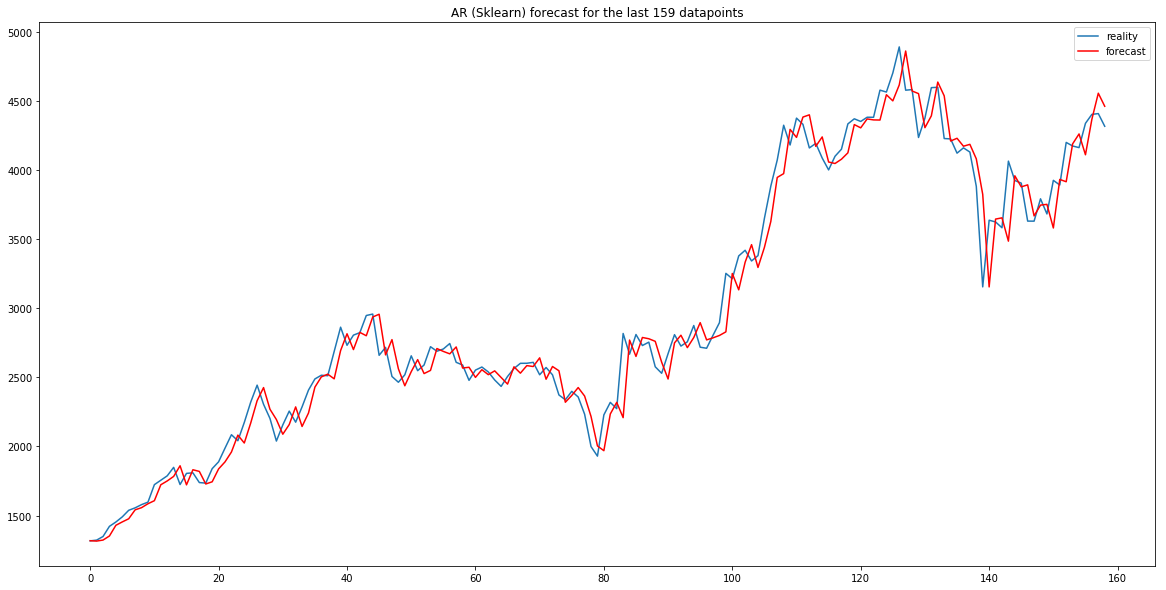

In [44]:
from sklearn.linear_model import LinearRegression

y=lagged_data['original'].values
X=lagged_data.drop('original',1).values

n=len(X)
n_train=int(ratio_train*n)
n_test=n-n_train
X_train,X_test=X[:n_train],X[n_train:]
y_train,y_test=y[:n_train],y[n_train:]

linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)

print('Lag: %s' % lagmax)
print('Coefficients: %s' % linear_reg.coef_)
print('')

pred_ar_train_sk = linear_reg.predict(X_train)
pred_ar_test_sk = linear_reg.predict(X_test)

ar_mse_train_sk = mean_squared_error(y_train,pred_ar_train_sk)
ar_mae_train_sk = mean_absolute_error(y_train,pred_ar_train_sk)
ar_r2_train_sk = r2_score(y_train,pred_ar_train_sk)

ar_mse_test_sk = mean_squared_error(y_test,pred_ar_test_sk)
ar_mae_test_sk = mean_absolute_error(y_test,pred_ar_test_sk)
ar_r2_test_sk = r2_score(y_test,pred_ar_test_sk)

print('Train MSE: %.3f' % ar_mse_train_sk)
print('Train MAE: %.3f' % ar_mae_train_sk)
print('Train R2: %.3f' % ar_r2_train_sk)
print('')
print('Test MSE: %.3f' % ar_mse_test_sk)
print('Test MAE: %.3f' % ar_mae_test_sk)
print('Test R2: %.3f' % ar_r2_test_sk)

# plot results
plt.figure(figsize=(20,10))
#plt.plot(X_train)
#plt.plot([None for i in X_train] + [x for x in X_test])
#plt.plot([None for i in X_train] + [x for x in pred_ar_test], color='red')
plt.plot(y_test, label='reality')
plt.plot(pred_ar_test_sk, label='forecast', color='red')
plt.title('AR (Sklearn) forecast for the last %d datapoints'%n_test)
plt.legend()
plt.show()

#### Sklearn AR model with log transformation

Lag: 30
Coefficients: [  9.84810440e-01  -1.94801090e-02   2.85836842e-02   7.92598899e-02
  -4.51735232e-02   5.42597004e-02  -9.21076740e-02  -2.74254794e-03
   1.73481086e-03   3.72963286e-02   3.93221840e-02  -7.80500608e-02
   3.66558807e-02   6.56197183e-03  -2.77865363e-02  -1.54944468e-03
   6.59220928e-02  -1.01530524e-01  -4.97395695e-02   1.15814097e-01
  -5.71272954e-02   6.99131573e-02  -8.62143099e-02   2.59595514e-02
  -2.10528928e-02   1.04075932e-01  -2.97378615e-02  -8.24137452e-02
   4.21821834e-02  -3.67954157e-04]

Train MSE: 0.000
Train MAE: 0.011
Train R2: 0.996

Test MSE: 0.001
Test MAE: 0.016
Test R2: 0.974


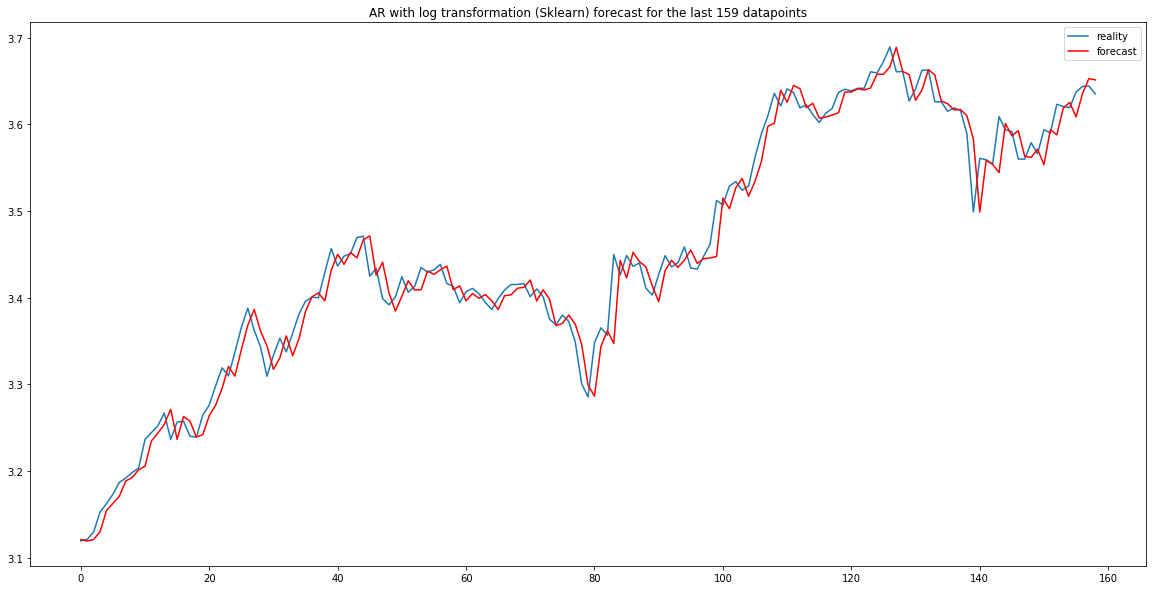

In [49]:
lagged_data_log = pd.concat([close_price_ts_log]+[close_price_ts_log.shift(i) for i in all_lags],axis=1,
                       keys=['original']+['Lag%d' % j for j in all_lags]).dropna()

y_log=lagged_data_log['original'].values
X_log=lagged_data_log.drop('original',1).values

n=len(X)
n_train=int(ratio_train*n)
n_test=n-n_train
X_train_log,X_test_log=X_log[:n_train],X_log[n_train:]
y_train_log,y_test_log=y_log[:n_train],y_log[n_train:]

linear_reg_log = LinearRegression()
linear_reg_log.fit(X_train_log,y_train)

print('Lag: %s' % lagmax)
print('Coefficients: %s' % linear_reg_log.coef_)
print('')

pred_ar_train_sk_log = linear_reg_log.predict(X_train_log)
pred_ar_test_sk_log = linear_reg_log.predict(X_test_log)

ar_mse_train_sk_log = mean_squared_error(y_train_log,pred_ar_train_sk_log)
ar_mae_train_sk_log = mean_absolute_error(y_train_log,pred_ar_train_sk_log)
ar_r2_train_sk_log = r2_score(y_train_log,pred_ar_train_sk_log)

ar_mse_test_sk_log = mean_squared_error(y_test_log,pred_ar_test_sk_log)
ar_mae_test_sk_log = mean_absolute_error(y_test_log,pred_ar_test_sk_log)
ar_r2_test_sk_log = r2_score(y_test_log,pred_ar_test_sk_log)

print('Train MSE: %.3f' % ar_mse_train_sk_log)
print('Train MAE: %.3f' % ar_mae_train_sk_log)
print('Train R2: %.3f' % ar_r2_train_sk_log)
print('')
print('Test MSE: %.3f' % ar_mse_test_sk_log)
print('Test MAE: %.3f' % ar_mae_test_sk_log)
print('Test R2: %.3f' % ar_r2_test_sk_log)

# plot results
plt.figure(figsize=(20,10))
#plt.plot(X_train)
#plt.plot([None for i in X_train] + [x for x in X_test])
#plt.plot([None for i in X_train] + [x for x in pred_ar_test], color='red')
plt.plot(y_test_log, label='reality')
plt.plot(pred_ar_test_sk_log, label='forecast', color='red')
plt.title('AR with log transformation (Sklearn) forecast for the last %d datapoints'%n_test)
plt.legend()
plt.show()

## ARIMA model

The signal shows a clear trend. Because of that, it is most likely not stationary. It will require differencing to make it sationary (at least a difference order of 1). 

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1619
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8731.852
Method:                       css-mle   S.D. of innovations             53.218
Date:                Thu, 02 Nov 2017   AIC                          17477.704
Time:                        12:12:28   BIC                          17515.430
Sample:                    04-29-2013   HQIC                         17491.704
                         - 10-03-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5834      1.245      2.076      0.038       0.144       5.023
ar.L1.D.Close    -0.0583      0.025     -2.346      0.019      -0.107      -0.010
ar.L2.D.Close     0.0097      0.025     

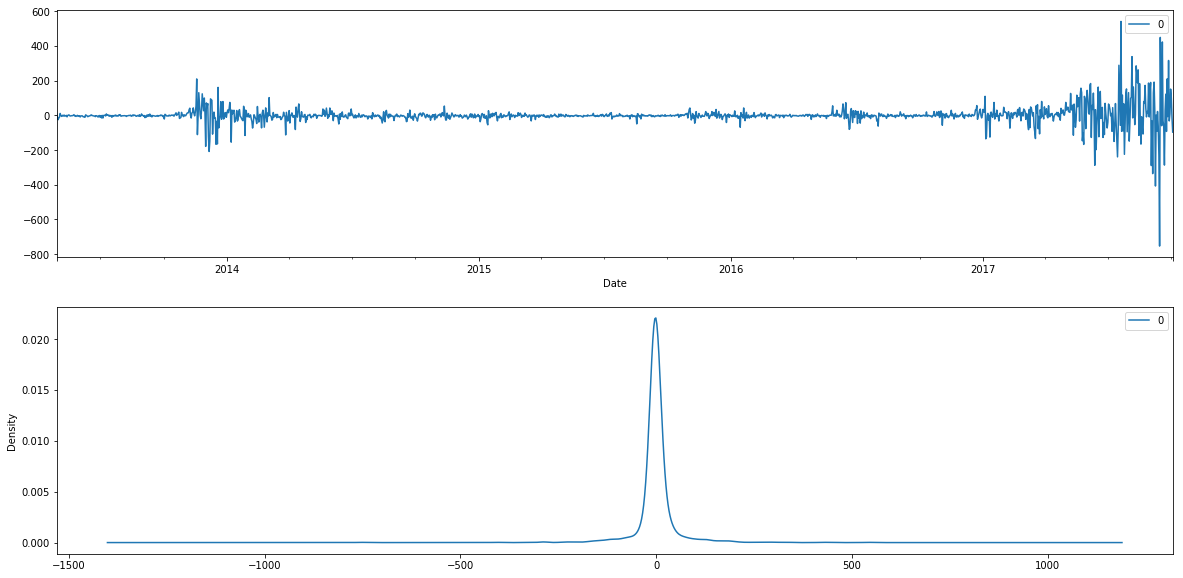

                 0
count  1619.000000
mean      0.000014
std      53.235012
min    -753.686205
25%      -7.258046
50%      -2.064297
75%       5.188200
max     541.498986


In [88]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(close_price_ts, order=(5, 1, 0))

arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# plot residual errors

residuals = pd.DataFrame(arima_model_fit.resid)

fig=plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(211)
residuals.plot(ax=ax1)

ax2 = fig.add_subplot(212)
residuals.plot(kind='kde',ax=ax2)

plt.show()
print(residuals.describe())

Trend seems to be removed.
Unbiased prediction (residual mean very close to 0).

### Rolling forecast ARIMA


Test MSE: 24717.980
Test MAE: 108.688
Test R2: 0.973


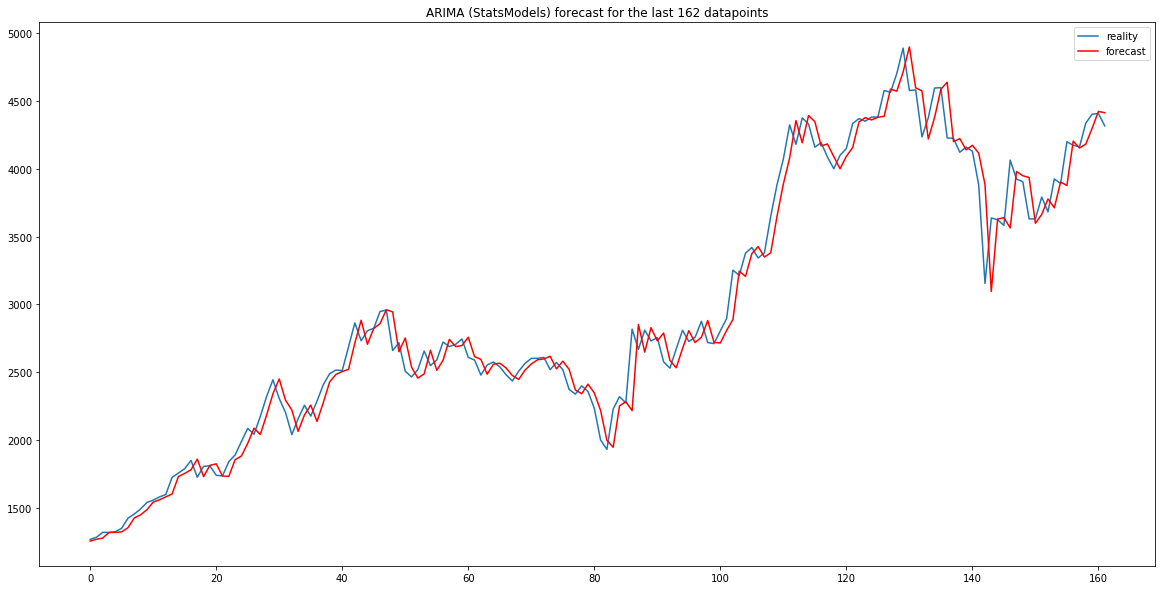

In [103]:
X = close_price_ts.copy()

n=len(X)
n_train=int(ratio_train*n)
n_test=n-n_train
X_train,X_test=X[:n_train],X[n_train:]

history=[x for x in X_train]
predictions=[]

for i in range(len(X_test)):
    arima_model = ARIMA(history, order=(5, 1, 0))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast(steps=1)
    pred_i=output[0]
    predictions.append(pred_i)
    obs_i=X_test[i]
    history.append(obs_i)
    
    
arima_mse_test = mean_squared_error(X_test,predictions)
arima_mae_test = mean_absolute_error(X_test,predictions)
arima_r2_test = r2_score(X_test,predictions)

print('')
print('Test MSE: %.3f' % arima_mse_test)
print('Test MAE: %.3f' % arima_mae_test)
print('Test R2: %.3f' % arima_r2_test)

# plot results
plt.figure(figsize=(20,10))
#plt.plot(X_train)
#plt.plot([None for i in X_train] + [x for x in X_test])
#plt.plot([None for i in X_train] + [x for x in pred_ar_test], color='red')
plt.plot(X_test.values, label='reality')
plt.plot(predictions, label='forecast', color='red')
plt.title('ARIMA (StatsModels) forecast for the last %d datapoints'%n_test)
plt.legend()
plt.show()

### Box-Jenkins method to find the best ARIMA model

Three steps:

* Model identification:
    * Make sure that the variables are stationary
    * Identify seasonality in the dependent variable
    * Use autocorrelation plot to decide which AR or MA component to choose, if any
* Parameter estimation
* Model checking
    * Residuals independent of each other
    * Residuals constant in mean and variance over time (plot mean and variance of residuals over time and perform Ljung-Box test or plot autocorrelation of residuals)
    * 
    
If **Model Checking** step fails, start again from **Model Identification**

#### Detect stationarity

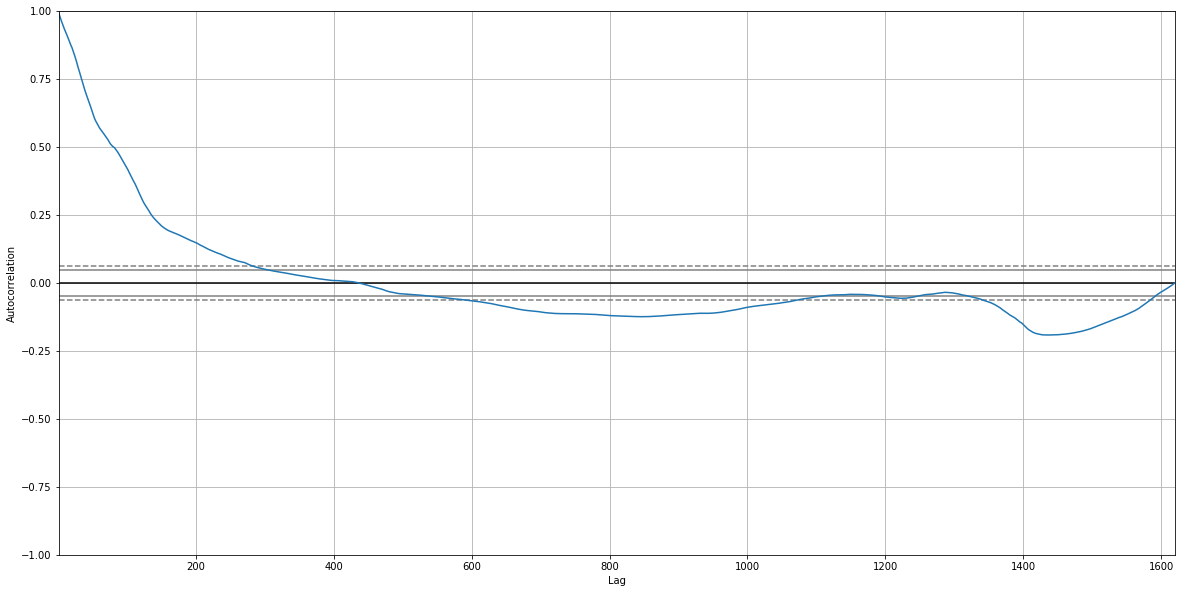

In [104]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,10))
autocorrelation_plot(close_price_ts)
plt.show()

The autocorrelation has a very small decay --> it indicates non-stationarity

The autocorrelation does not show seasonality neither

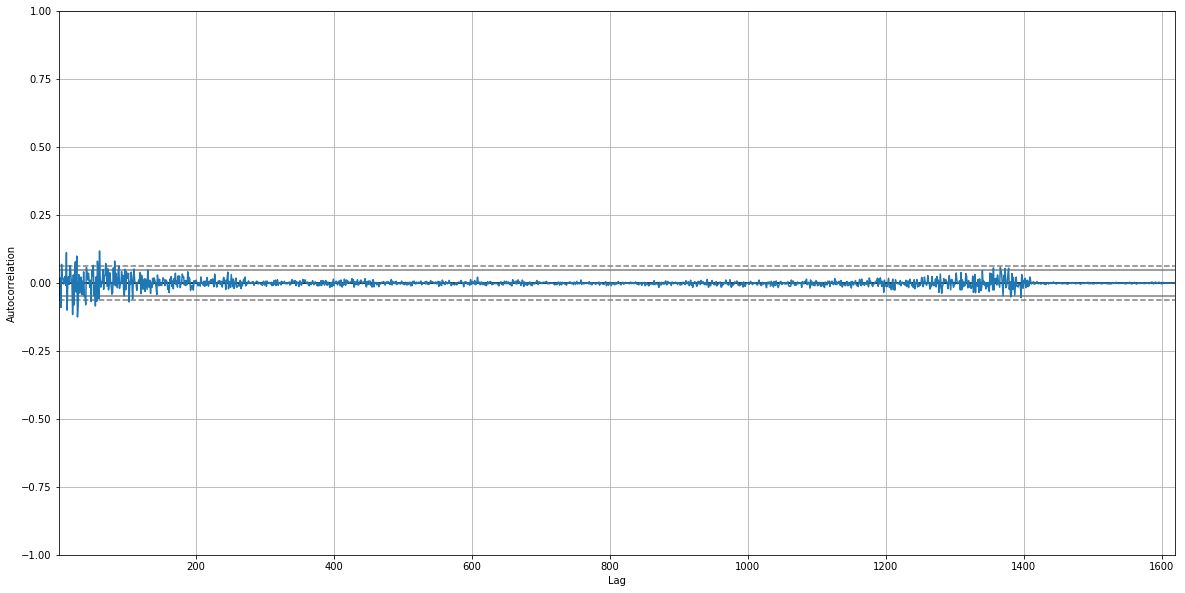

In [109]:
diff_data = close_price_ts.diff().dropna()
plt.figure(figsize=(20,10))
autocorrelation_plot(diff_data)
plt.show()